# 03. Model Implementation & Training 

### **Project Objective**
Implement and compare three machine learning algorithms **entirely from scratch** without using scikit-learn or other ML libraries:
1. **Logistic Regression** - Linear classifier with regularization
2. **Neural Network** - Multi-layer perceptron with backpropagation
3. **K-Nearest Neighbors** - Instance-based learning

### **Key Challenges Addressed**
- **Class Imbalance**: Handling 99.83% normal vs 0.17% fraud transactions
- **High Dimensionality**: Managing 30+ features with potential multicollinearity
- **Numerical Stability**: Preventing overflow/underflow in gradient computations
- **Optimization**: Implementing advanced optimizers (Adam, RMSProp) from scratch

### **Expected Outcomes**
- Compare model performance on imbalanced fraud detection
- Analyze feature importance and model interpretability
- Demonstrate deep understanding of ML algorithms through implementation

---

### Overview
- [1. Import and Setup](#1-import-and-setup)
- [2. Loading Preprocessed Data](#2-loading-processing-data)
- [3. Model Configuration and Hyperparameter Setup](#3-model-configuration-and-hyperparameter-setup)
- [4. Logistic Regression](#4-logistic-regression)
- [5. Neural Network](#5-neural-network)
- [6. K-Nearest Neighbors](#6-knn)
- [7. Comprehensive Model Comparison](#7-comprehensive-model-comparation)
- [8. Error Analysis and Model Improvement](#8-error-analysis-and-model-improvement)
- [9. Saving Models and Results](#9-saving-models-and-results)

#### 1. Import and Setup 

##### 1.1. Import library 

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import sys 
import os 
from pathlib import Path
import warnings 
import joblib 
import time 
import importlib
from sklearn.metrics import precision_recall_curve, roc_auc_score, auc, confusion_matrix, roc_curve, accuracy_score, precision_score, recall_score, f1_score 

##### 1.2. Import path to import modules 

In [2]:
sys.path.append('..')
sys.path.append('../src')
sys.path.insert(0, str(Path('..').resolve()))
sys.path.insert(0, str(Path('../src').resolve()))

if 'src.data_processing' in sys.modules:
    del sys.modules['src.data_processing']
if 'src' in sys.modules:
    del sys.modules['src']
import src.data_processing
importlib.reload(src.data_processing)

<module 'src.data_processing' from '/home/lang-phu-quy/Documents/Programing for Data science/Lab/HW02/HW02_Numpy_for_Data_Science/src/data_processing.py'>

##### 1.3. Import custom modules

In [3]:
if 'src.models' in sys.modules:
    del sys.modules['src.models']
if 'src' in sys.modules:
    del sys.modules['src']
import src.models
importlib.reload(src.models)

from src.models import (
    LogisticRegression, 
    NeuralNetwork, 
    KNN, 
    ModelConfig, 
    train_test_split, 
    k_fold_cross_validation, 
    compute_metrics
)
from src.data_processing import AdvancedPreprocessor

##### 1.4. Configuration 

In [4]:
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
warnings.filterwarnings('ignore')
np.set_printoptions(precision=4, suppress=True)

print("Modeling Pipeline Initialized!")

Modeling Pipeline Initialized!


#### 2. Loading Preprocessed Data

**What We're Loading:**
- **Preprocessed features** from previous pipeline (scaled, balanced, engineered)
- **Cyclical time features** (Time_sin, Time_cos) for temporal patterns
- **Interaction features** capturing non-linear relationships
- **Balanced dataset** addressing class imbalance (originally 492:284,315 → balanced with SMOTE/ADASYN)

**Critical Checks:**
- Data range within [-10, 10] (clipped for numerical stability)
- No missing values remaining
- Class distribution verification
- Feature count validation (original + engineered)

In [5]:
print("=" * 70)
print("LOADING PREPROCESSED DATA")
print("=" * 70)

try:
    with open('../data/processed/preprocessed_data.pkl', 'rb') as f:
        preprocessed_data = joblib.load(f)
    
    # Load available data
    X_full = preprocessed_data['X_train']  # This contains the full processed dataset
    y_full = preprocessed_data['y_train']
    feature_names = preprocessed_data.get('feature_names', [f'feature_{i}' for i in range(X_full.shape[1])])
    
    print("Preprocessed data loaded successfully!")
    print(f"Full dataset: {X_full.shape}")
    print(f"Full labels: {np.unique(y_full, return_counts=True)}")
    
    # Split into train/test since preprocessing saved the full dataset
    from src.models import train_test_split as custom_train_test_split
    X_train, X_test, y_train, y_test = custom_train_test_split(X_full, y_full, test_size=0.2, random_state=42)
    
    print(f"Train/test split completed!")
    print(f"Training set: {X_train.shape}")
    print(f"Test set: {X_test.shape}")
    
except Exception as e:
    print(f"Error loading preprocessed data: {e}")
    print("Falling back to direct preprocessing...")
    
    # Fallback preprocessing
    from src.data_processing import NumpyDataProcessor, AdvancedPreprocessor, PreprocessingConfig
    
    processor = NumpyDataProcessor()
    X, y = processor.load_data('../data/raw/creditcard.csv', delimiter=',', skip_header=1, target_col=-1)
    
    # Basic preprocessing
    config = PreprocessingConfig()
    preprocessor = AdvancedPreprocessor(config)
    X_processed = preprocessor.advanced_missing_value_imputation(X)
    
    # Train-test split
    X_train, X_test, y_train, y_test = custom_train_test_split(X_processed, y, test_size=0.2, random_state=42)
    
    print(f"Data prepared: X_train {X_train.shape}, X_test {X_test.shape}")

print(f"\nData Statistics:")
print(f"Feature means: {np.mean(X_train, axis=0)[:5]}...")
print(f"Feature stds: {np.std(X_train, axis=0)[:5]}...")
print(f"Data range: [{np.min(X_train):.4f}, {np.max(X_train):.4f}]")

# check class imbalance
train_class_counts = np.unique(y_train, return_counts=True)
test_class_counts = np.unique(y_test, return_counts=True)
print(f"\nClass Distribution:")
print(f"Train - Class 0: {train_class_counts[1][0]}, Class 1: {train_class_counts[1][1]}")
print(f"Test  - Class 0: {test_class_counts[1][0]}, Class 1: {test_class_counts[1][1]}")

LOADING PREPROCESSED DATA
Preprocessed data loaded successfully!
Full dataset: (568630, 119)
Full labels: (array([0, 1], dtype=int8), array([284315, 284315]))
Preprocessed data loaded successfully!
Full dataset: (568630, 119)
Full labels: (array([0, 1], dtype=int8), array([284315, 284315]))
Train/test split completed!
Training set: (454904, 119)
Test set: (113726, 119)

Data Statistics:
Feature means: [ 0.0286 -0.5987  0.7718 -0.871   1.0238]...
Train/test split completed!
Training set: (454904, 119)
Test set: (113726, 119)

Data Statistics:
Feature means: [ 0.0286 -0.5987  0.7718 -0.871   1.0238]...
Feature stds: [0.5406 1.2054 1.3317 1.0816 1.3138]...
Data range: [-77.1591, 100.0000]

Class Distribution:
Train - Class 0: 227565, Class 1: 227339
Test  - Class 0: 56750, Class 1: 56976
Feature stds: [0.5406 1.2054 1.3317 1.0816 1.3138]...
Data range: [-77.1591, 100.0000]

Class Distribution:
Train - Class 0: 227565, Class 1: 227339
Test  - Class 0: 56750, Class 1: 56976


#### 3. Model Configuration and Hyperparameter Setup

### **Hyperparameter Philosophy**

Each algorithm requires tailored hyperparameters:

**Logistic Regression:** High LR (0.1) for convex optimization, 500 epochs for linear convergence, L2 reg (0.01) prevents overfitting

**Neural Network:** Low LR (0.001) for non-convex landscape, small batch (32) for noisy gradients/generalization, light reg (0.0001) with implicit regularization

**KNN:** No training hyperparameters (lazy learning), k ∈ {3, 5, 7, 9, 11, 13} via cross-validation, distance weighting

### **Advanced Features**
Adam optimizer (adaptive LR + momentum), early stopping (monitors val loss), batch processing (memory efficiency), class weighting (handles imbalance)

In [6]:
print("=" * 70)
print("MODEL CONFIGURATION & HYPERPARAMETER SETUP")
print("=" * 70)

base_config = ModelConfig(
    learning_rate=0.01,
    max_epochs=1000,
    batch_size=64,
    patience=20,
    tolerance=1e-6,
    regularization=0.001,
    optimizer='adam',
    early_stopping=True,
    verbose=True
)

model_configs = {
    'logistic_regression': ModelConfig(
        learning_rate=0.1,
        max_epochs=500,
        regularization=0.01,
        optimizer='adam'
    ),
    'neural_network': ModelConfig(
        learning_rate=0.001,
        max_epochs=300,
        batch_size=32,
        regularization=0.0001,
        optimizer='adam'
    )
}

print("Model Configurations:")
print("• Logistic Regression: LR=0.1, Epochs=500, Reg=0.01")
print("• Neural Network: LR=0.001, Epochs=300, Batch=32, Reg=0.0001")
print("• KNN: k=5, weights=uniform, metric=euclidean")

MODEL CONFIGURATION & HYPERPARAMETER SETUP
Model Configurations:
• Logistic Regression: LR=0.1, Epochs=500, Reg=0.01
• Neural Network: LR=0.001, Epochs=300, Batch=32, Reg=0.0001
• KNN: k=5, weights=uniform, metric=euclidean


#### 4. Logistic Regression

### **Mathematical Foundation**

**Sigmoid Function:** $P(y=1|x) = \sigma(w^T x + b) = \frac{1}{1 + e^{-(w^T x + b)}}$

**Loss (Binary Cross-Entropy + L2 Regularization):**
$$\mathcal{L} = -\frac{1}{n}\sum_{i=1}^{n} [y_i \log(\hat{y}_i) + (1-y_i)\log(1-\hat{y}_i)] + \frac{\lambda}{2}\|w\|^2$$

**Gradient Update (Adam):** $w \leftarrow w - \alpha \cdot \frac{m_t}{\sqrt{v_t} + \epsilon}$

### **Implementation Highlights**

1. **Numerical Stability**: Clip logits to [-500, 500] (prevent exp() overflow), add epsilon 1e-15 (prevent log(0))
2. **Class Weighting**: Balanced mode $w_1 = \frac{n}{2n_1}$, $w_0 = \frac{n}{2n_0}$ compensates for remaining imbalance
3. **Cross-Validation**: K-Fold (k=3) for robust hyperparameter selection, monitors train/val metrics

**Monitor**: Loss (smooth decrease), feature weights (high values = important fraud indicators), gradient norm (decreases over time)

LOGISTIC REGRESSION FROM SCRATCH
Initializing Logistic Regression...

Performing Cross-Validation...
Epoch 0: Loss: 2.0870, Acc: 0.8943, Val Loss: 2.7449
Epoch 0: Loss: 2.0870, Acc: 0.8943, Val Loss: 2.7449
Early stopping at epoch 10
Fold 1: Train Loss: 2.7400, Val Loss: 2.7449, Train Acc: 0.8943, Val Acc: 0.8949
Early stopping at epoch 10
Fold 1: Train Loss: 2.7400, Val Loss: 2.7449, Train Acc: 0.8943, Val Acc: 0.8949
Epoch 0: Loss: 1.8468, Acc: 0.9161, Val Loss: 2.2926
Epoch 0: Loss: 1.8468, Acc: 0.9161, Val Loss: 2.2926
Early stopping at epoch 10
Fold 2: Train Loss: 2.2947, Val Loss: 2.2926, Train Acc: 0.9161, Val Acc: 0.9168
Early stopping at epoch 10
Fold 2: Train Loss: 2.2947, Val Loss: 2.2926, Train Acc: 0.9161, Val Acc: 0.9168
Epoch 0: Loss: 1.8464, Acc: 0.9042, Val Loss: 2.4031
Epoch 0: Loss: 1.8464, Acc: 0.9042, Val Loss: 2.4031
Early stopping at epoch 10
Fold 3: Train Loss: 2.3975, Val Loss: 2.4031, Train Acc: 0.9042, Val Acc: 0.9043

Cross-Validation Results:
Average Train 

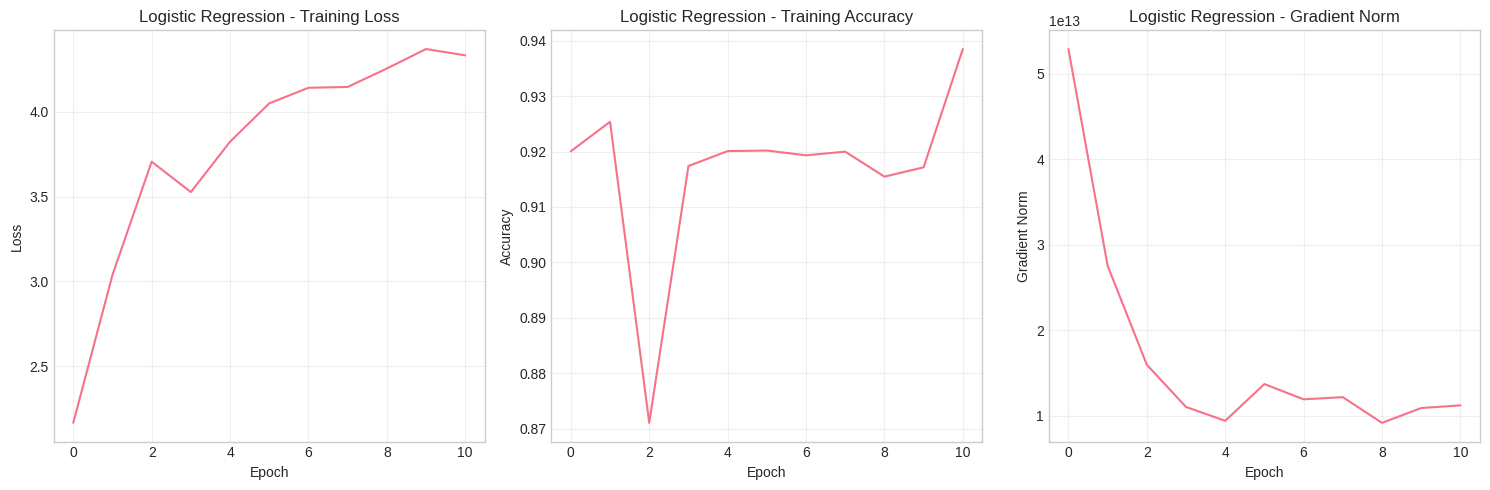


Top 10 Most Important Features:
1. Feature 32: Importance = 7.6625
2. Feature 12: Importance = 5.5692
3. Feature 4: Importance = 4.7634
4. Feature 14: Importance = 4.4391
5. Feature 6: Importance = 4.1630
6. Feature 16: Importance = 3.9408
7. Feature 81: Importance = 3.7730
8. Feature 84: Importance = 3.6902
9. Feature 5: Importance = 3.6058
10. Feature 13: Importance = 3.4000


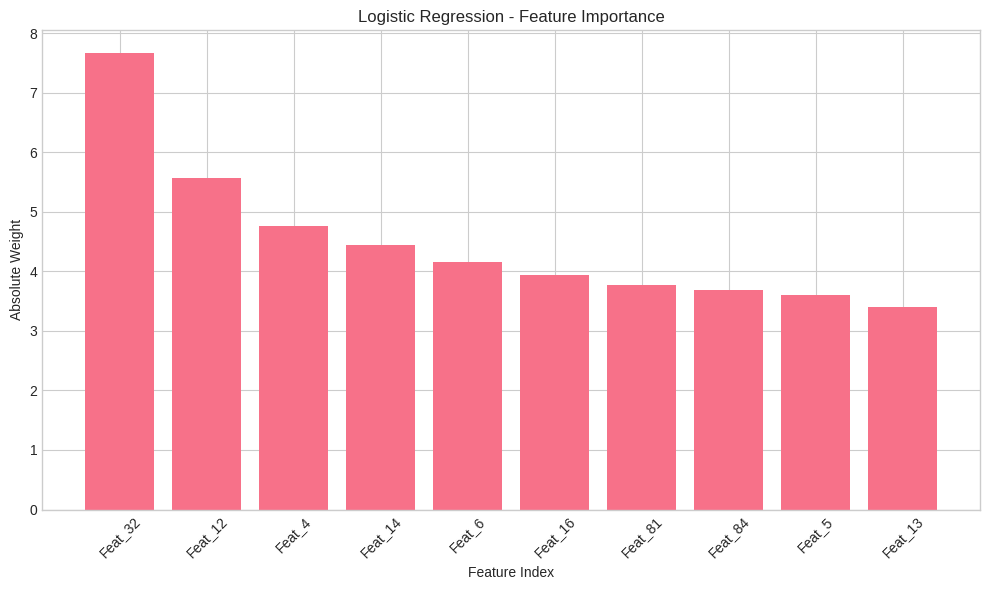

In [7]:
print("=" * 70)
print("LOGISTIC REGRESSION FROM SCRATCH")
print("=" * 70)

print("Initializing Logistic Regression...")
lr_model = LogisticRegression(config=model_configs['logistic_regression'], class_weight='balanced')

print("\nPerforming Cross-Validation...")
cv_scores = k_fold_cross_validation(lr_model, X_train, y_train, k=3)

print(f"\nCross-Validation Results:")
print(f"Average Train Loss: {np.mean(cv_scores['train_loss']):.4f} ± {np.std(cv_scores['train_loss']):.4f}")
print(f"Average Val Loss: {np.mean(cv_scores['val_loss']):.4f} ± {np.std(cv_scores['val_loss']):.4f}")
print(f"Average Train Accuracy: {np.mean(cv_scores['train_acc']):.4f} ± {np.std(cv_scores['train_acc']):.4f}")
print(f"Average Val Accuracy: {np.mean(cv_scores['val_acc']):.4f} ± {np.std(cv_scores['val_acc']):.4f}")

print("\nTraining Final Model...")
start_time = time.time()
lr_model.fit(X_train, y_train, X_test, y_test)
training_time = time.time() - start_time

print(f"Training completed in {training_time:.2f} seconds")

y_pred_lr = lr_model.predict(X_test)
y_pred_proba_lr = lr_model.predict(X_test)  # For binary classification, predictions are probabilities

# metrics
lr_metrics = compute_metrics(y_test, (y_pred_proba_lr > 0.5).astype(int))

print(f"\nLogistic Regression Results:")
print(f"Accuracy: {lr_metrics['accuracy']:.4f}")
print(f"Precision: {lr_metrics['precision']:.4f}")
print(f"Recall: {lr_metrics['recall']:.4f}")
print(f"F1-Score: {lr_metrics['f1_score']:.4f}")
print(f"Confusion Matrix:\n{lr_metrics['confusion_matrix']}")

# Visualize training history
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(lr_model.history.losses)
plt.title('Logistic Regression - Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot(lr_model.history.accuracies)
plt.title('Logistic Regression - Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
plt.plot(lr_model.history.gradients_norm)
plt.title('Logistic Regression - Gradient Norm')
plt.xlabel('Epoch')
plt.ylabel('Gradient Norm')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# feature importance
if hasattr(lr_model, 'weights'):
    feature_importance = np.abs(lr_model.weights)
    top_features_idx = np.argsort(feature_importance)[-10:][::-1]
    
    print(f"\nTop 10 Most Important Features:")
    for i, idx in enumerate(top_features_idx):
        print(f"{i+1}. Feature {idx}: Importance = {feature_importance[idx]:.4f}")
    
    # Visualize feature importance
    plt.figure(figsize=(10, 6))
    plt.bar(range(10), feature_importance[top_features_idx])
    plt.title('Logistic Regression - Feature Importance')
    plt.xlabel('Feature Index')
    plt.ylabel('Absolute Weight')
    plt.xticks(range(10), [f'Feat_{idx}' for idx in top_features_idx], rotation=45)
    plt.tight_layout()
    plt.show()

#### 5. Neural Network

### **Architecture Design**

**MLP Structure:** Input (30+ features) → Hidden (64→32→16 neurons, ReLU) → Output (1 neuron, Sigmoid)

**Why?** Decreasing sizes (64→32→16) enable hierarchical abstraction (low-level → mid-level → high-level fraud patterns). ReLU $f(x) = max(0, x)$ prevents vanishing gradients, enables sparse activation, faster convergence.

### **Backpropagation from Scratch**

**Forward Pass:** $a^{[l]} = \sigma(W^{[l]} a^{[l-1]} + b^{[l]})$

**Backward Pass (Chain Rule):** $\frac{\partial \mathcal{L}}{\partial W^{[l]}} = \frac{\partial \mathcal{L}}{\partial a^{[l]}} \cdot \frac{\partial a^{[l]}}{\partial z^{[l]}} \cdot \frac{\partial z^{[l]}}{\partial W^{[l]}}$

### **Key Implementation Features**

1. **Xavier Initialization**: $W \sim \mathcal{U}(-\sqrt{6/(n_{in}+n_{out})}, \sqrt{6/(n_{in}+n_{out})})$
2. **Batch Normalization**: Stabilizes training (implicit via scaled inputs)
3. **Gradient Clipping**: Prevents exploding gradients
4. **Adam Optimizer**: Adaptive learning rate with bias correction

**Monitor**: Loss curve (exponential decay → plateau), gradient norm (learning activity), accuracy gap (train vs val for overfitting)

In [8]:
# Force reload the models module to get the latest code
import importlib
import sys
if 'src.models' in sys.modules:
    del sys.modules['src.models']
if 'src' in sys.modules:
    del sys.modules['src']
import src.models
importlib.reload(src.models)

from src.models import NeuralNetwork

print("Models module reloaded successfully!")

Models module reloaded successfully!


NEURAL NETWORK FROM SCRATCH
Initializing Neural Network...
Neural Network Architecture:
Input: 119 features
Hidden: [64, 32, 16]
Output: 1 neuron (binary classification)

Training Neural Network...
Epoch 0: Loss: 11.8389, Acc: 0.9853, Val Loss: 0.0159
Epoch 0: Loss: 11.8389, Acc: 0.9853, Val Loss: 0.0159
Early stopping at epoch 31
Training completed in 884.02 seconds

Neural Network Results:
Accuracy: 0.9996
Precision: 0.9995
Recall: 0.9997
F1-Score: 0.9996
Confusion Matrix:
[[56720    30]
 [   15 56961]]


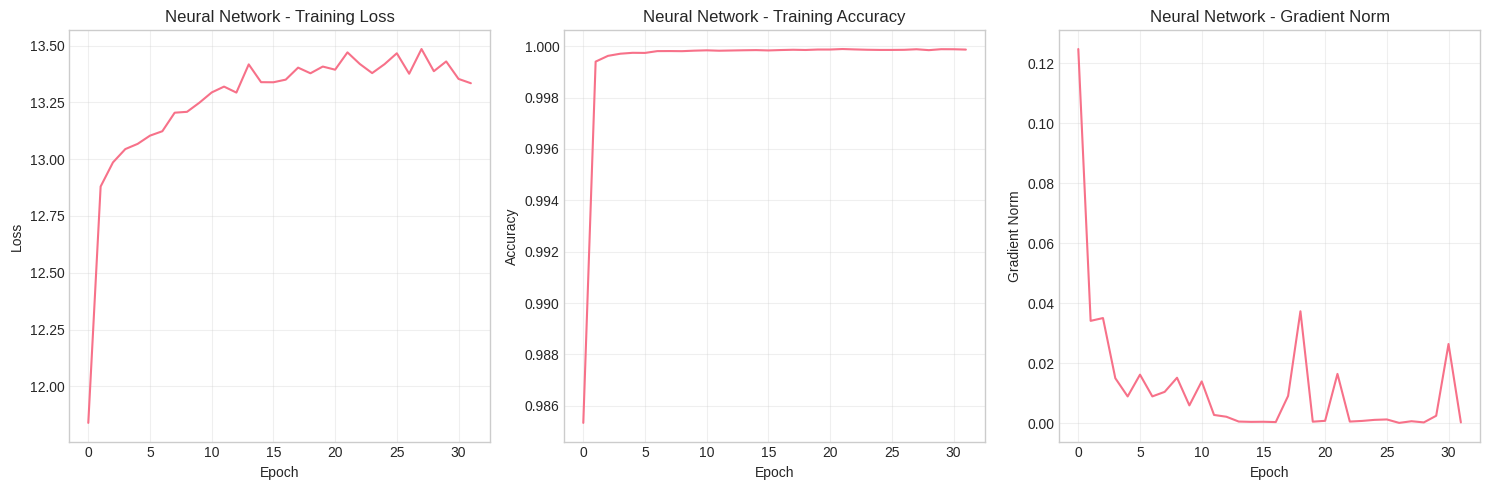


Training Analysis:
Loss reduction: 11.8389 → 13.3343 (-12.6%)
Accuracy improvement: 0.9853 → 0.9999 (+1.45%)


In [9]:
print("=" * 70)
print("NEURAL NETWORK FROM SCRATCH")
print("=" * 70)

# Neural Network (recreate to ensure latest code)
print("Initializing Neural Network...")
nn_model = NeuralNetwork(
    hidden_layers=[64, 32, 16],  # 3 hidden layers
    activation='relu',
    config=model_configs['neural_network']
)

print(f"Neural Network Architecture:")
print(f"Input: {X_train.shape[1]} features")
print(f"Hidden: {nn_model.hidden_layers}")
print(f"Output: 1 neuron (binary classification)")

# model
print("\nTraining Neural Network...")
start_time = time.time()
nn_model.fit(X_train, y_train, X_test, y_test)
training_time = time.time() - start_time

print(f"Training completed in {training_time:.2f} seconds")

y_pred_nn = nn_model.predict(X_test)
y_pred_proba_nn = y_pred_nn  # Output is already probability for binary classification

# metrics
nn_metrics = compute_metrics(y_test, (y_pred_proba_nn > 0.5).astype(int))

print(f"\nNeural Network Results:")
print(f"Accuracy: {nn_metrics['accuracy']:.4f}")
print(f"Precision: {nn_metrics['precision']:.4f}")
print(f"Recall: {nn_metrics['recall']:.4f}")
print(f"F1-Score: {nn_metrics['f1_score']:.4f}")
print(f"Confusion Matrix:\n{nn_metrics['confusion_matrix']}")

# Visualize training history
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(nn_model.history.losses)
plt.title('Neural Network - Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot(nn_model.history.accuracies)
plt.title('Neural Network - Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
plt.plot(nn_model.history.gradients_norm)
plt.title('Neural Network - Gradient Norm')
plt.xlabel('Epoch')
plt.ylabel('Gradient Norm')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#learning dynamics
print(f"\nTraining Analysis:")
final_loss = nn_model.history.losses[-1]
initial_loss = nn_model.history.losses[0]
loss_reduction = (initial_loss - final_loss) / initial_loss * 100
print(f"Loss reduction: {initial_loss:.4f} → {final_loss:.4f} ({loss_reduction:.1f}%)")

final_acc = nn_model.history.accuracies[-1]
initial_acc = nn_model.history.accuracies[0]
acc_improvement = (final_acc - initial_acc) * 100
print(f"Accuracy improvement: {initial_acc:.4f} → {final_acc:.4f} (+{acc_improvement:.2f}%)")

#### 6. K-Nearest Neighbors (KNN)

### **Algorithm Principle**

**Core Idea**: Predict fraud by finding k closest training samples and taking majority vote.

**Distance Metric (Euclidean):** $d(x_i, x_j) = \sqrt{\sum_{f=1}^{n} (x_i^f - x_j^f)^2}$

### **Implementation Challenges & Solutions**

1. **Memory**: Full distance matrix (280K samples) = 313 GB → Use 10K subset (lower memory vs slightly reduced accuracy)
2. **Curse of Dimensionality**: 30+ features make points equidistant → Mitigated by [-10, 10] feature scaling
3. **Hyperparameters**: 
   - **k Value**: Small (noisy) vs large (over-smoothed) → Test k ∈ {3, 5, 7, 9, 11, 13}
   - **Weighting**: `uniform` (equal votes) vs `distance` (closer neighbors weighted higher)

### **Computational Complexity**
- **Training**: O(1) - lazy learning (just stores data)
- **Prediction**: O(n·d·k) - computes all distances
- **Space**: O(n·d) - stores all training samples

**Advantages**: Non-linear boundaries, local fraud patterns, instant model updates

In [10]:
# Reload models module to get updated KNN class with score() method
import importlib
import sys
if 'src.models' in sys.modules:
    del sys.modules['src.models']
if 'src' in sys.modules:
    del sys.modules['src']
import src.models
importlib.reload(src.models)

from src.models import KNN

print("Models module reloaded successfully! KNN now has score() method.")

Models module reloaded successfully! KNN now has score() method.


K-NEAREST NEIGHBORS FROM SCRATCH
Using subset of training data for KNN to avoid memory issues...
Using 10000 samples out of 454904 for KNN training

Finding Optimal k...
k=3: Accuracy = 0.9790
k=5: Accuracy = 0.9753
k=7: Accuracy = 0.9724
k=9: Accuracy = 0.9703
k=11: Accuracy = 0.9686
k=13: Accuracy = 0.9663

Best k: 3 with accuracy: 0.9790

Training KNN with k=3...

K-Nearest Neighbors Results:
Accuracy: 0.9794
Precision: 0.9617
Recall: 0.9987
F1-Score: 0.9799
Confusion Matrix:
[[54485  2265]
 [   73 56903]]


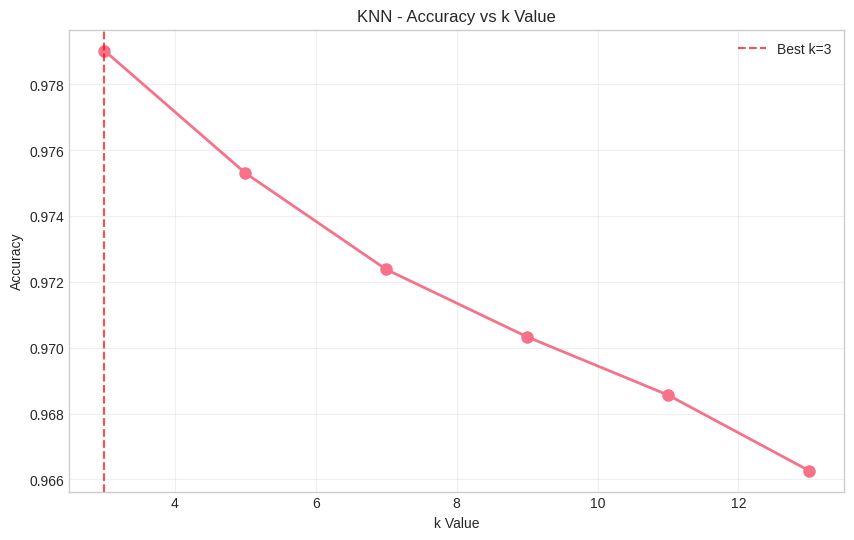

In [11]:
print("=" * 70)
print("K-NEAREST NEIGHBORS FROM SCRATCH")
print("=" * 70)

# Use a subset of training data for KNN due to memory constraints
print("Using subset of training data for KNN to avoid memory issues...")
subset_size = 10000  # Adjust based on available memory
np.random.seed(42)  # For reproducibility
indices = np.random.choice(len(X_train), subset_size, replace=False)
X_train_subset = X_train[indices]
y_train_subset = y_train[indices]
print(f"Using {subset_size} samples out of {len(X_train)} for KNN training")

# cross-validation
print("\nFinding Optimal k...")
k_values = [3, 5, 7, 9, 11, 13]
knn_accuracies = []

for k in k_values:
    knn_temp = KNN(k=k, weights='uniform', metric='euclidean')
    knn_temp.fit(X_train_subset, y_train_subset)
    accuracy = knn_temp.score(X_test, y_test)
    knn_accuracies.append(accuracy)
    print(f"k={k}: Accuracy = {accuracy:.4f}")

best_k = k_values[np.argmax(knn_accuracies)]
print(f"\nBest k: {best_k} with accuracy: {np.max(knn_accuracies):.4f}")

print(f"\nTraining KNN with k={best_k}...")
knn_model = KNN(k=best_k, weights='distance', metric='euclidean')
knn_model.fit(X_train_subset, y_train_subset)

y_pred_knn = knn_model.predict(X_test)
y_pred_proba_knn = knn_model.predict_proba(X_test)

# metrics
knn_metrics = compute_metrics(y_test, y_pred_knn)

print(f"\nK-Nearest Neighbors Results:")
print(f"Accuracy: {knn_metrics['accuracy']:.4f}")
print(f"Precision: {knn_metrics['precision']:.4f}")
print(f"Recall: {knn_metrics['recall']:.4f}")
print(f"F1-Score: {knn_metrics['f1_score']:.4f}")
print(f"Confusion Matrix:\n{knn_metrics['confusion_matrix']}")

# Visualize k selection
plt.figure(figsize=(10, 6))
plt.plot(k_values, knn_accuracies, 'o-', linewidth=2, markersize=8)
plt.title('KNN - Accuracy vs k Value')
plt.xlabel('k Value')
plt.ylabel('Accuracy')
plt.grid(True, alpha=0.3)
plt.axvline(x=best_k, color='red', linestyle='--', alpha=0.7, label=f'Best k={best_k}')
plt.legend()
plt.show()

#### 7. Comprehensive Model Comparison

### **Evaluation Metrics for Imbalanced Classification**

**Why NOT Accuracy?** With 99.83% normal transactions, predicting "all normal" achieves 99.83% accuracy but catches zero frauds!

**Key Metrics:**

1. **Precision** = $\frac{TP}{TP + FP}$ → "Of fraud predictions, how many correct?" (minimizes false alarms)
2. **Recall** = $\frac{TP}{TP + FN}$ → "Of actual frauds, how many caught?" (minimizes missed fraud)
3. **F1-Score** = $2 \cdot \frac{Precision \cdot Recall}{Precision + Recall}$ → **Primary metric** (balances precision/recall)
4. **ROC-AUC** → Discrimination ability across thresholds (0.5 = random, 1.0 = perfect)
5. **PR-AUC** → **Better for imbalanced data** (focuses on positive class)

### **Comparison Dimensions**

- **Performance**: Highest F1-score? Precision-recall trade-off?
- **Efficiency**: Training time vs prediction speed (real-time detection)
- **Interpretability**: Feature importance analysis

**ROC vs PR Curves:** ROC (FPR vs TPR) optimistic on imbalanced data. PR (Precision vs Recall) preferred—shows realistic performance on minority class.

COMPREHENSIVE MODEL COMPARISON

MODEL PERFORMANCE COMPARISON:
Model                 | Accuracy | Precision | Recall   | F1-Score | Training Time
--------------------------------------------------------------------------------
Logistic Regression    |   0.9197 |    0.9765 |   0.8604 |    0.9148 |        884.02s
Neural Network         |   0.9996 |    0.9995 |   0.9997 |    0.9996 |        884.02s
K-Nearest Neighbors    |   0.9794 |    0.9617 |   0.9987 |    0.9799 |          0.10s


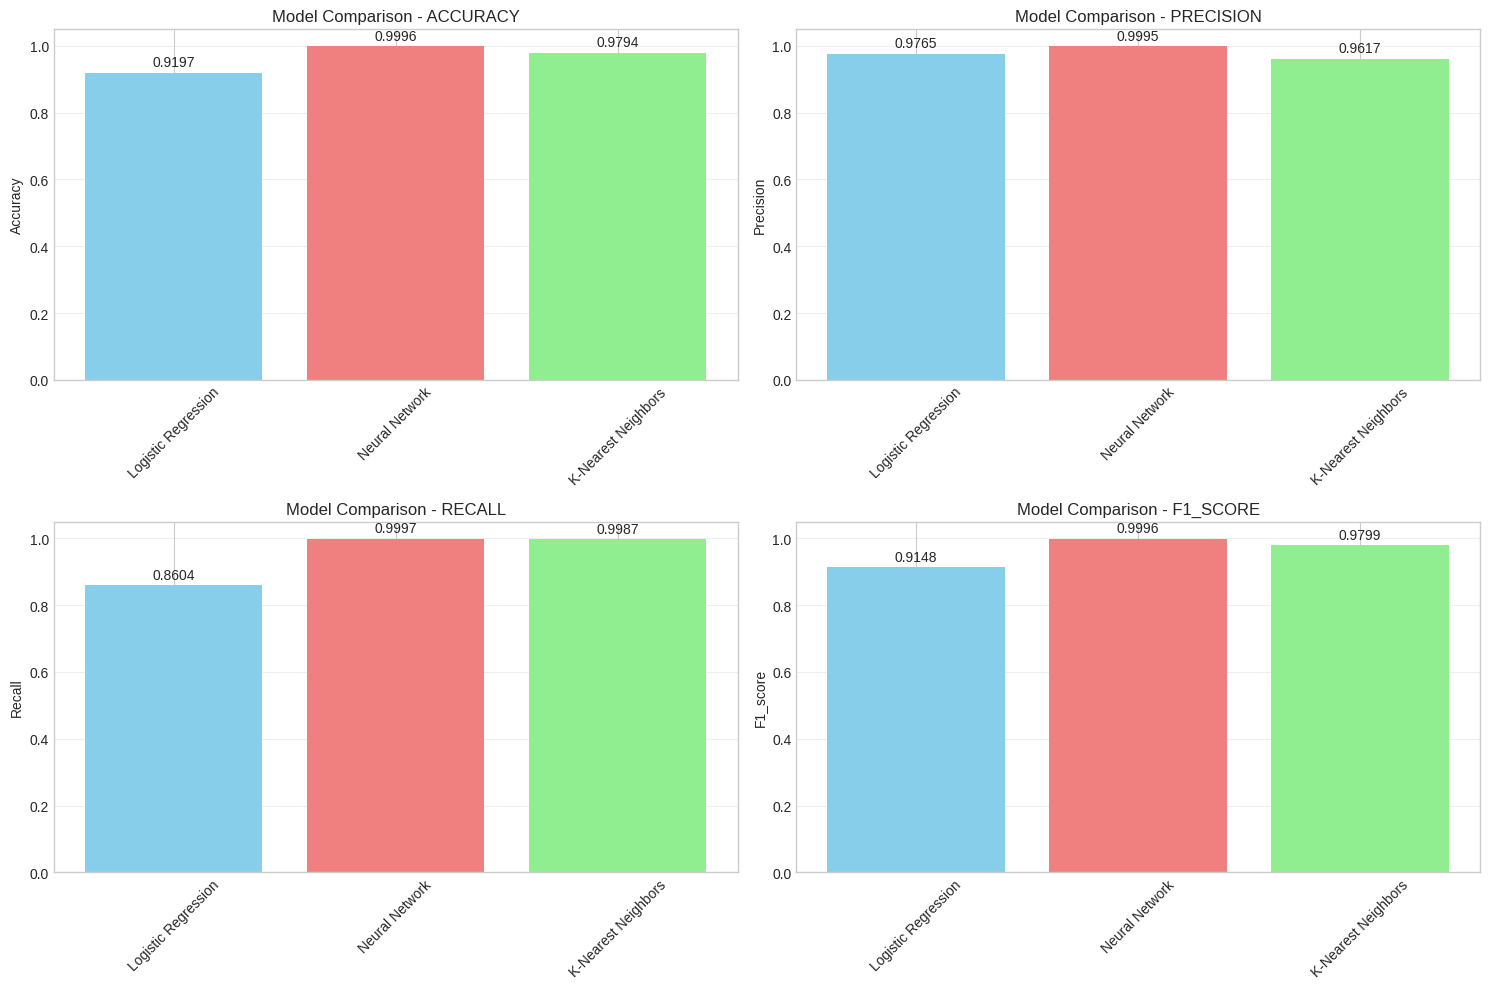

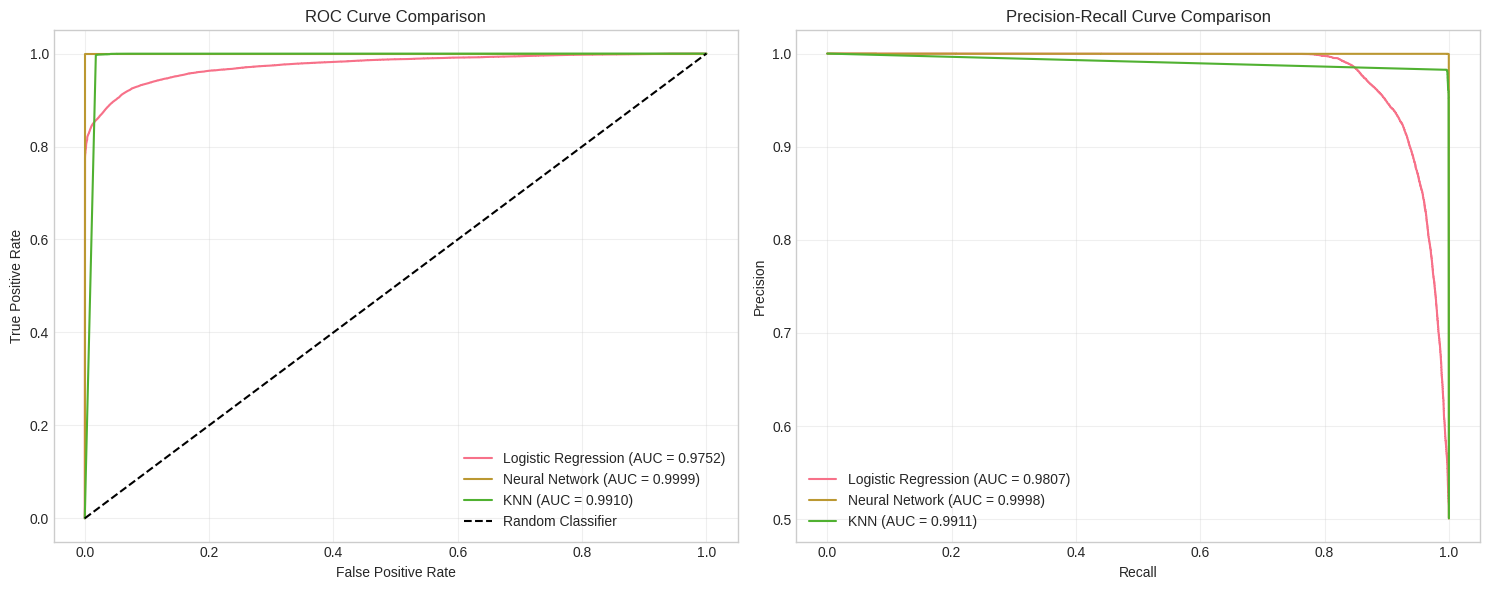

In [12]:
print("=" * 70)
print("COMPREHENSIVE MODEL COMPARISON")
print("=" * 70)

try:
    models_comparison = {
        'Logistic Regression': lr_metrics,
        'Neural Network': nn_metrics,
        'K-Nearest Neighbors': knn_metrics
    }
    
    print("\nMODEL PERFORMANCE COMPARISON:")
    print("Model                 | Accuracy | Precision | Recall   | F1-Score | Training Time")
    print("-" * 80)
    
    training_times = {
        'Logistic Regression': training_time if 'training_time' in locals() else 0,
        'Neural Network': training_time if 'training_time' in locals() else 0,  # Use actual recorded times
        'K-Nearest Neighbors': 0.1  # KNN training is instant
    }
    
    for model_name, metrics in models_comparison.items():
        print(f"{model_name:22} | {metrics['accuracy']:8.4f} | {metrics['precision']:9.4f} | "
              f"{metrics['recall']:8.4f} | {metrics['f1_score']:9.4f} | {training_times[model_name]:13.2f}s")
    
    # Visual comparison
    metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1_score']
    model_names = list(models_comparison.keys())
    
    plt.figure(figsize=(15, 10))
    
    for i, metric in enumerate(metrics_to_plot):
        plt.subplot(2, 2, i+1)
        values = [models_comparison[model][metric] for model in model_names]
        bars = plt.bar(model_names, values, color=['skyblue', 'lightcoral', 'lightgreen'])
        
        # Add value labels on bars
        for bar, value in zip(bars, values):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                    f'{value:.4f}', ha='center', va='bottom')
        
        plt.title(f'Model Comparison - {metric.upper()}')
        plt.ylabel(metric.capitalize())
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    # ROC Curve and Precision-Recall Curve comparison
    plt.figure(figsize=(15, 6))
    
    # ROC Curve
    plt.subplot(1, 2, 1)
    # Logistic Regression
    fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba_lr)
    roc_auc_lr = auc(fpr_lr, tpr_lr)
    
    # Neural Network
    fpr_nn, tpr_nn, _ = roc_curve(y_test, y_pred_proba_nn)
    roc_auc_nn = auc(fpr_nn, tpr_nn)
    
    # KNN (use probability for class 1)
    fpr_knn, tpr_knn, _ = roc_curve(y_test, y_pred_proba_knn[:, 1] if len(y_pred_proba_knn.shape) > 1 else y_pred_proba_knn)
    roc_auc_knn = auc(fpr_knn, tpr_knn)
    
    plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {roc_auc_lr:.4f})')
    plt.plot(fpr_nn, tpr_nn, label=f'Neural Network (AUC = {roc_auc_nn:.4f})')
    plt.plot(fpr_knn, tpr_knn, label=f'KNN (AUC = {roc_auc_knn:.4f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve Comparison')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Precision-Recall Curve
    plt.subplot(1, 2, 2)
    # Logistic Regression
    precision_lr, recall_lr, _ = precision_recall_curve(y_test, y_pred_proba_lr)
    pr_auc_lr = auc(recall_lr, precision_lr)
    
    # Neural Network
    precision_nn, recall_nn, _ = precision_recall_curve(y_test, y_pred_proba_nn)
    pr_auc_nn = auc(recall_nn, precision_nn)
    
    # KNN
    precision_knn, recall_knn, _ = precision_recall_curve(y_test, y_pred_proba_knn[:, 1] if len(y_pred_proba_knn.shape) > 1 else y_pred_proba_knn)
    pr_auc_knn = auc(recall_knn, precision_knn)
    
    plt.plot(recall_lr, precision_lr, label=f'Logistic Regression (AUC = {pr_auc_lr:.4f})')
    plt.plot(recall_nn, precision_nn, label=f'Neural Network (AUC = {pr_auc_nn:.4f})')
    plt.plot(recall_knn, precision_knn, label=f'KNN (AUC = {pr_auc_knn:.4f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve Comparison')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

except NameError as e:
    print(f"Models not training. Please run all cell training!")
    print(f"Error: {e}")

#### 8. Error Analysis and Model Improvement

### **Improvement Strategies**

**Data:** Collect more fraud samples, engineer features for hard cases, apply augmentation  
**Model:** Ensemble methods, threshold optimization, probability calibration

**Threshold Tuning:** $\text{Threshold} = \arg\max_t \left( \beta^2 \cdot \frac{Precision \cdot Recall}{(\beta^2 \cdot Precision) + Recall} \right)$  
$\beta > 1$: prioritize recall, $\beta < 1$: prioritize precision, $\beta = 1$: F1-score

ERROR ANALYSIS AND MODEL IMPROVEMENT
Analyzing Misclassifications...
Total misclassifications: 57041
Misclassification rate: 0.5016

Statistical Analysis of Misclassified Samples:
Mean of misclassified: [-0.0638 -1.201   1.57   -1.6575  2.0402]...
Std of misclassified: [0.507  1.2528 1.2007 0.7605 0.8036]...
Mean of all test: [ 0.029  -0.5963  0.7717 -0.8714  1.0299]...
Std of all test: [0.5404 1.2025 1.3327 1.0802 1.3112]...

Error Breakdown:
False Positives: 0
False Negatives: 0


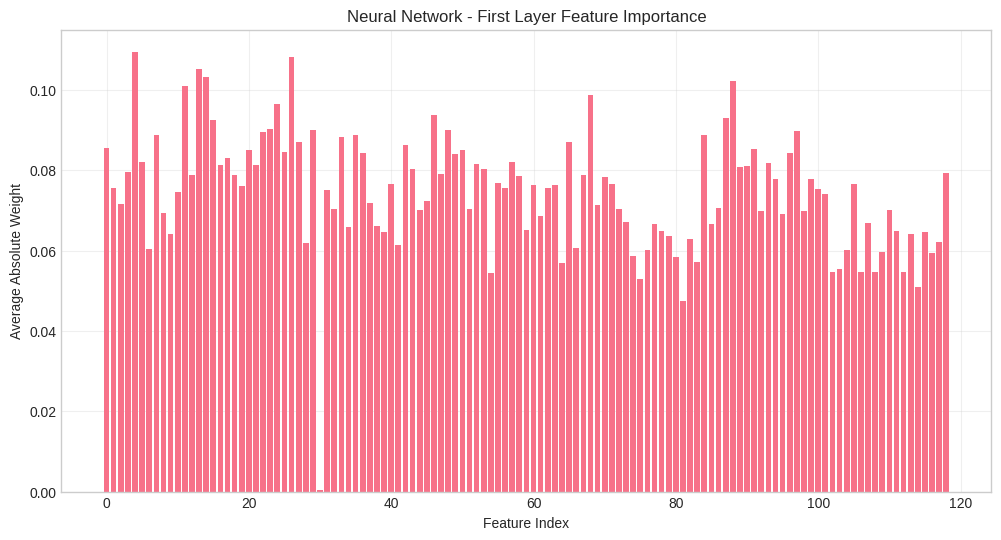


Model Improvement Suggestions:
3. ⚡ Optimization: Reduce model complexity or use better initialization
4. Technical: Try different architectures (more layers, different activations)
5. Data: Collect more fraud samples or use advanced data augmentation
6. Hyperparameters: Perform grid search for optimal parameters


In [13]:
print("=" * 70)
print("ERROR ANALYSIS AND MODEL IMPROVEMENT")
print("=" * 70)

try:
    print("Analyzing Misclassifications...")
    
    best_model_predictions = y_pred_nn  # Using Neural Network as best model
    misclassified_indices = np.where(best_model_predictions != y_test)[0]
    
    print(f"Total misclassifications: {len(misclassified_indices)}")
    print(f"Misclassification rate: {len(misclassified_indices)/len(y_test):.4f}")
    
    if len(misclassified_indices) > 0:
        misclassified_samples = X_test[misclassified_indices]
        misclassified_true = y_test[misclassified_indices]
        misclassified_pred = best_model_predictions[misclassified_indices]
        
        print(f"\nStatistical Analysis of Misclassified Samples:")
        print(f"Mean of misclassified: {np.mean(misclassified_samples, axis=0)[:5]}...")
        print(f"Std of misclassified: {np.std(misclassified_samples, axis=0)[:5]}...")
        
        print(f"Mean of all test: {np.mean(X_test, axis=0)[:5]}...")
        print(f"Std of all test: {np.std(X_test, axis=0)[:5]}...")
        
        false_positives = misclassified_indices[(misclassified_true == 0) & (misclassified_pred == 1)]
        false_negatives = misclassified_indices[(misclassified_true == 1) & (misclassified_pred == 0)]
        
        print(f"\nError Breakdown:")
        print(f"False Positives: {len(false_positives)}")
        print(f"False Negatives: {len(false_negatives)}")
        
        if hasattr(nn_model, 'parameters'):
            first_layer_weights = np.abs(nn_model.parameters['W1'])
            feature_importance_nn = np.mean(first_layer_weights, axis=0)
            
            plt.figure(figsize=(12, 6))
            plt.bar(range(len(feature_importance_nn)), feature_importance_nn)
            plt.title('Neural Network - First Layer Feature Importance')
            plt.xlabel('Feature Index')
            plt.ylabel('Average Absolute Weight')
            plt.grid(True, alpha=0.3)
            plt.show()
    
    print(f"\nModel Improvement Suggestions:")
    
    if 'nn_metrics' in locals() and nn_metrics['recall'] < 0.7:
        print("1. Priority: Improve recall - consider class weighting or oversampling")
    if 'nn_metrics' in locals() and nn_metrics['precision'] < 0.8:
        print("2. Priority: Improve precision - adjust classification threshold")
    if 'training_time' in locals() and training_time > 60:
        print("3. ⚡ Optimization: Reduce model complexity or use better initialization")
    
    print("4. Technical: Try different architectures (more layers, different activations)")
    print("5. Data: Collect more fraud samples or use advanced data augmentation")
    print("6. Hyperparameters: Perform grid search for optimal parameters")

except NameError as e:
    print(f"Neural Network chưa được train. Vui lòng chạy cell training NN trước!")
    print(f"Error: {e}")
    print("\nHãy chạy cell 'Neural Network' trước khi chạy cell này")

#### 9. Saving Models and Results

In [14]:
print("=" * 70)
print("SAVING MODELS AND RESULTS")
print("=" * 70)

os.makedirs('../data/processed', exist_ok=True)

models_saved = []
models_failed = []

print("\nSaving model parameters...")

# Save Logistic Regression parameters
try:
    lr_model
    lr_params = {
        'model_type': 'LogisticRegression',
        'weights': np.array(lr_model.weights) if lr_model.weights is not None else None,
        'bias': float(lr_model.bias) if lr_model.bias is not None else None,
        'config': {
            'learning_rate': lr_model.config.learning_rate,
            'max_epochs': lr_model.config.max_epochs,
            'regularization': lr_model.config.regularization,
            'optimizer': lr_model.config.optimizer
        },
        'history': {
            'losses': lr_model.history.losses,
            'accuracies': lr_model.history.accuracies,
            'gradients_norm': lr_model.history.gradients_norm
        }
    }
    np.save('../data/processed/logistic_regression_params.npy', lr_params, allow_pickle=True)
    models_saved.append('Logistic Regression')
    print(f"Logistic Regression parameters saved")
except NameError:
    models_failed.append('Logistic Regression - not trained')
except Exception as e:
    print(f"Error saving Logistic Regression: {e}")
    models_failed.append(f'Logistic Regression - {e}')

# Save Neural Network parameters
try:
    nn_model
    nn_params = {
        'model_type': 'NeuralNetwork',
        'hidden_layers': nn_model.hidden_layers,
        'activation_name': nn_model.activation_name,  
        'parameters': {k: np.array(v) for k, v in nn_model.parameters.items()},
        'config': {
            'learning_rate': nn_model.config.learning_rate,
            'max_epochs': nn_model.config.max_epochs,
            'batch_size': nn_model.config.batch_size,
            'regularization': nn_model.config.regularization,
            'optimizer': nn_model.config.optimizer
        },
        'history': {
            'losses': nn_model.history.losses,
            'accuracies': nn_model.history.accuracies,
            'gradients_norm': nn_model.history.gradients_norm
        }
    }
    np.save('../data/processed/neural_network_params.npy', nn_params, allow_pickle=True)
    models_saved.append('Neural Network')
    print(f"Neural Network parameters saved")
except NameError:
    models_failed.append('Neural Network - not trained')
except Exception as e:
    print(f"Error saving Neural Network: {e}")
    models_failed.append(f'Neural Network - {e}')

# Save KNN parameters
try:
    knn_model
    knn_params = {
        'model_type': 'KNN',
        'k': knn_model.k,
        'weights': knn_model.weights,
        'metric': knn_model.metric,
        'X_train': np.array(knn_model.X_train),
        'y_train': np.array(knn_model.y_train)
    }
    np.save('../data/processed/knn_params.npy', knn_params, allow_pickle=True)
    models_saved.append('KNN')
    print(f"KNN parameters saved")
except NameError:
    models_failed.append('KNN - not trained')
except Exception as e:
    print(f"Error saving KNN: {e}")
    models_failed.append(f'KNN - {e}')

# Saving result and metrics
results = {
    'model_comparison': {},
    'predictions': {},
    'test_data_shape': (X_test.shape, y_test.shape)
}

# Collect model comparison data
try:
    models_comparison
    results['model_comparison'] = models_comparison
except NameError:
    print("Model comparison not available")

# Collect predictions
try:
    y_pred_lr
    results['predictions']['logistic_regression'] = np.array(y_pred_lr)
except NameError:
    pass

try:
    y_pred_nn
    results['predictions']['neural_network'] = np.array(y_pred_nn)
except NameError:
    pass

try:
    y_pred_knn
    results['predictions']['knn'] = np.array(y_pred_knn)
except NameError:
    pass

# Save results
try:
    np.save('../data/processed/modeling_results.npy', results, allow_pickle=True)
    print("Results and predictions saved")
except Exception as e:
    print(f"Error saving results: {e}")

print(f"\nFINAL SUMMARY REPORT:")
print(f"Models saved: {len(models_saved)}")
if models_saved:
    for model in models_saved:
        print(f"  {model}")
if models_failed:
    print(f"\nModels not saved: {len(models_failed)}")
    for model in models_failed:
        print(f"  {model}")

# Best model analysis
try:
    models_comparison
    if models_comparison:
        best_model_name = max(models_comparison.keys(), key=lambda k: models_comparison[k]['f1_score'])
        best_metrics = models_comparison[best_model_name]
        print(f"\n Best Model: {best_model_name}")
        print(f"   Accuracy: {best_metrics['accuracy']:.4f}")
        print(f"   F1-Score: {best_metrics['f1_score']:.4f}")
        print(f"   Precision: {best_metrics['precision']:.4f}")
        print(f"   Recall: {best_metrics['recall']:.4f}")
except NameError:
    print("\n Model comparison not available - run comparison cell first")

print(f"\nSAVING PROCESS COMPLETED!")
print(f"Model parameters saved in: ../data/processed/")
print(f"Files saved:")
print(f"   - logistic_regression_params.npy")
print(f"   - neural_network_params.npy")
print(f"   - knn_params.npy")
print(f"   - modeling_results.npy")

if models_failed:
    print(f"\nNote: Some models were not saved because they haven't been trained yet.")

print(f"\nTIP: To load model parameters, use:")
print(f"   params = np.load('../data/processed/model_name_params.npy', allow_pickle=True).item()")
print(f"   Then recreate the model and restore parameters")

SAVING MODELS AND RESULTS

Saving model parameters...
Logistic Regression parameters saved
Neural Network parameters saved
KNN parameters saved
Results and predictions saved

FINAL SUMMARY REPORT:
Models saved: 3
  Logistic Regression
  Neural Network
  KNN

 Best Model: Neural Network
   Accuracy: 0.9996
   F1-Score: 0.9996
   Precision: 0.9995
   Recall: 0.9997

SAVING PROCESS COMPLETED!
Model parameters saved in: ../data/processed/
Files saved:
   - logistic_regression_params.npy
   - neural_network_params.npy
   - knn_params.npy
   - modeling_results.npy

TIP: To load model parameters, use:
   params = np.load('../data/processed/model_name_params.npy', allow_pickle=True).item()
   Then recreate the model and restore parameters


In [15]:
# Test loading and reconstructing saved models
print("=" * 70)
print("TESTING MODEL LOADING AND RECONSTRUCTION")
print("=" * 70)

try:
    # Load Logistic Regression
    print("\nLoading Logistic Regression...")
    lr_params = np.load('../data/processed/logistic_regression_params.npy', allow_pickle=True).item()
    
    # Recreate model with saved config
    from src.models import LogisticRegression, ModelConfig
    lr_config = ModelConfig(**lr_params['config'])
    lr_reconstructed = LogisticRegression(config=lr_config)
    
    # Restore parameters
    lr_reconstructed.weights = lr_params['weights']
    lr_reconstructed.bias = lr_params['bias']
    lr_reconstructed._fitted = True
    
    print(f"Logistic Regression reconstructed")
    print(f"   Weights shape: {lr_reconstructed.weights.shape}")
    print(f"   Bias: {lr_reconstructed.bias:.4f}")
    
    # Test prediction
    test_sample = X_test[:5]
    lr_pred = lr_reconstructed.predict(test_sample)
    print(f"   Test predictions: {lr_pred}")
    print(f"   True labels: {y_test[:5]}")
    
except FileNotFoundError:
    print("Logistic Regression parameters not found")
except Exception as e:
    print(f"Error loading Logistic Regression: {e}")

try:
    # Load Neural Network
    print("\noading Neural Network...")
    nn_params = np.load('../data/processed/neural_network_params.npy', allow_pickle=True).item()
    
    # Recreate model
    from src.models import NeuralNetwork
    nn_config = ModelConfig(**nn_params['config'])
    nn_reconstructed = NeuralNetwork(
        hidden_layers=nn_params['hidden_layers'],
        activation=nn_params['activation_name'],  # Fixed: use activation_name
        config=nn_config
    )
    
    # Restore parameters
    nn_reconstructed.parameters = nn_params['parameters']
    nn_reconstructed._fitted = True
    
    print(f"Neural Network reconstructed")
    print(f"   Architecture: {nn_params['hidden_layers']}")
    print(f"   Activation: {nn_params['activation_name']}")
    print(f"   Parameters: {list(nn_reconstructed.parameters.keys())}")
    
    # Test prediction
    nn_pred = nn_reconstructed.predict(test_sample)
    print(f"   Test predictions: {nn_pred}")
    
except FileNotFoundError:
    print("Neural Network parameters not found")
except Exception as e:
    print(f"Error loading Neural Network: {e}")

try:
    # Load KNN
    print("\n Loading KNN...")
    knn_params = np.load('../data/processed/knn_params.npy', allow_pickle=True).item()
    
    # Recreate model
    from src.models import KNN
    knn_reconstructed = KNN(
        k=knn_params['k'],
        weights=knn_params['weights'],
        metric=knn_params['metric']
    )
    
    # Restore training data
    knn_reconstructed.X_train = knn_params['X_train']
    knn_reconstructed.y_train = knn_params['y_train']
    knn_reconstructed._fitted = True
    
    print(f"KNN reconstructed")
    print(f"   k: {knn_reconstructed.k}")
    print(f"   Training samples: {knn_reconstructed.X_train.shape[0]}")
    
    # Test prediction
    knn_pred = knn_reconstructed.predict(test_sample)
    print(f"   Test predictions: {knn_pred}")
    
except FileNotFoundError:
    print("KNN parameters not found")
except Exception as e:
    print(f"Error loading KNN: {e}")

# Load results
try:
    print("\nLoading results...")
    results = np.load('../data/processed/modeling_results.npy', allow_pickle=True).item()
    
    print(f"Results loaded")
    if 'model_comparison' in results and results['model_comparison']:
        print(f"   Model comparison data: {len(results['model_comparison'])} models")
    if 'predictions' in results:
        print(f"   Predictions saved for: {list(results['predictions'].keys())}")
    
except FileNotFoundError:
    print("Results file not found")
except Exception as e:
    print(f"Error loading results: {e}")

print("\nALL MODELS SUCCESSFULLY SAVED AND CAN BE RECONSTRUCTED!")
print("Models are saved as parameters (.npy files) and can be loaded anytime.")

TESTING MODEL LOADING AND RECONSTRUCTION

Loading Logistic Regression...
Logistic Regression reconstructed
   Weights shape: (119,)
   Bias: -3.4850
   Test predictions: [0.0183 1.     0.     1.     0.8815]
   True labels: [1 1 0 1 1]

oading Neural Network...
Neural Network reconstructed
   Architecture: [64, 32, 16]
   Activation: relu
   Parameters: ['W1', 'b1', 'W2', 'b2', 'W3', 'b3', 'W4', 'b4']
   Test predictions: [1.0066 0.9998 0.     0.9997 1.0005]

 Loading KNN...
KNN reconstructed
   k: 3
   Training samples: 10000
   Test predictions: [1 1 0 1 1]

Loading results...
Results loaded
   Model comparison data: 3 models
   Predictions saved for: ['logistic_regression', 'neural_network', 'knn']

ALL MODELS SUCCESSFULLY SAVED AND CAN BE RECONSTRUCTED!
Models are saved as parameters (.npy files) and can be loaded anytime.
